In [48]:
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm import tqdm
import akshare as ak
from typing import List
import matplotlib.pyplot as plt

# 数据处理

读取收盘价数据，并进行检查

In [2]:
#字段管理
fields = {
    'S_DQ_ADJCLOSE': 'close',
    'S_INFO_WINDCODE': 'stkcd',
    'TRADE_DT': 'date',
    'S_DQ_VOLUME': 'volume'
}

#读取数据的预处理
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    del df['Unnamed: 0']
    df.rename(columns=fields, inplace=True)
    df['date'] = df['date'].astype(str)
    return df
    

In [3]:
close_df = pd.read_csv("./MD/CLOSE.csv")
close_df = preprocess(close_df)
close_df.head()

,close,stkcd,date
0,2001.16,000001.SZ,20210901
1,3388.19,000002.SZ,20210901
2,75.51,000004.SZ,20210901
3,21.87,000005.SZ,20210901
4,174.99,000006.SZ,20210901


某些股票股价在很长一段时间内不变，且成交量为0  
例子如下

In [4]:
volume_df = pd.read_csv('./MD/S_DQ_VOLUME.csv')
volume_df = preprocess(volume_df)
close_df = pd.merge(close_df, volume_df, on=['stkcd', 'date'])

In [5]:
#本地数据
close_df[close_df['stkcd']=='873169.BJ'].iloc[20:40]

,close,stkcd,date,volume
98215,10.75,873169.BJ,20211008,0.0
102913,10.75,873169.BJ,20211011,0.0
107610,10.75,873169.BJ,20211012,0.0
112309,10.75,873169.BJ,20211013,0.0
117009,10.75,873169.BJ,20211014,0.0
121711,10.75,873169.BJ,20211015,0.0
126415,10.75,873169.BJ,20211018,0.0
131123,10.75,873169.BJ,20211019,0.0
135834,10.75,873169.BJ,20211020,0.0
140548,10.75,873169.BJ,20211021,0.0


In [6]:
#akshare东财接口历史数据
ak.stock_zh_a_hist('873169', 'daily', '20210901', '20220501')

,日期,开盘,收盘,最高,最低,成交量,成交额,振幅,涨跌幅,涨跌额,换手率
0,2021-09-07,4.65,4.65,4.65,4.65,1,465.0,0.00,-33.57,-2.35,0.00
1,2021-09-10,5.28,5.28,5.28,5.28,2,1056.0,0.00,13.55,0.63,0.00
2,2021-09-13,5.51,5.51,5.51,5.51,18,9918.0,0.00,4.36,0.23,0.04
3,2021-09-22,11.00,11.00,11.00,11.00,22,24200.0,0.00,99.64,5.49,0.04
4,2021-09-23,10.00,10.60,10.60,10.00,14,14600.0,5.45,-3.64,-0.40,0.03
5,2021-09-24,10.66,10.75,10.75,10.66,70,74950.0,0.85,1.42,0.15,0.14
6,2022-04-15,6.81,7.32,8.86,6.61,118142,89187165.0,37.50,22.00,1.32,49.09
7,2022-04-18,6.80,6.36,6.80,6.29,69164,44989380.0,6.97,-13.11,-0.96,28.74
8,2022-04-19,6.40,6.29,6.40,6.15,28918,18056879.0,3.93,-1.10,-0.07,12.02
9,2022-04-20,6.30,6.13,6.34,6.09,23386,14444087.0,3.97,-2.54,-0.16,9.72


无论是由于停牌，还是流动性过差，成交量为0的股票是比较异常的；而东财的接口也未统计成交量为0时的交易数据  
综合考虑，我剔除了成交量为0的数据

In [7]:
close_df = close_df[close_df['volume']!=0]

构造因子，需要计算月度收益率  
可能由于停牌，某些股票某些月份的交易日太少，处于异常状态，下面剔除月内交易日过少的数据

In [8]:
close_df['month'] = close_df['date'].apply(lambda x: x[:6])
close_df.head()

,close,stkcd,date,volume,month
0,2001.16,000001.SZ,20210901,2316894.09,202109
1,3388.19,000002.SZ,20210901,1251790.18,202109
2,75.51,000004.SZ,20210901,40542.00,202109
3,21.87,000005.SZ,20210901,608189.79,202109
4,174.99,000006.SZ,20210901,150387.04,202109


月内交易日描述性统计

In [9]:
groups = close_df.groupby(['stkcd', 'month'])
counts = groups.apply(len)
print(counts.describe())
counts.quantile(0.05)

count    124329.000000
mean         19.220463
std           4.651075
min           1.000000
25%          19.000000
50%          20.000000
75%          22.000000
max          23.000000
dtype: float64


10.0

剔除月内交易日小于10的数据

In [10]:
counts = counts.reset_index()
counts.rename(columns={0:'days'}, inplace=True)
counts

,stkcd,month,days
0,000001.SZ,202109,20
1,000001.SZ,202110,16
2,000001.SZ,202111,22
3,000001.SZ,202112,23
4,000001.SZ,202201,19
...,...,...,...
124324,873593.BJ,202305,20
124325,873593.BJ,202306,20
124326,873593.BJ,202307,21
124327,873593.BJ,202308,23


In [11]:
close_df = pd.merge(close_df, counts, on=['stkcd', 'month'])
close_df = close_df[close_df['days'] > 10]
close_df.head()

,close,stkcd,date,volume,month,days
0,2001.16,000001.SZ,20210901,2316894.09,202109,20
1,2059.36,000001.SZ,20210902,2422603.54,202109,20
2,2019.07,000001.SZ,20210903,1394818.71,202109,20
3,2064.96,000001.SZ,20210906,1515225.56,202109,20
4,2153.38,000001.SZ,20210907,1622344.16,202109,20


剔除流动性较差的股票

转换成矩阵

In [12]:
close_df = close_df [['date', 'stkcd', 'close']]
close_df = close_df.pivot(index='date', columns='stkcd', values='close')
close_df.head()

stkcd,000001.SZ,000002.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,...,873122.BJ,873152.BJ,873167.BJ,873169.BJ,873223.BJ,873305.BJ,873339.BJ,873527.BJ,873576.BJ,873593.BJ
date,,,,,,,,,,,,,,,,,,,,,
20210901,2001.16,3388.19,75.51,21.87,174.99,33.96,51.31,224.84,39.97,47.67,...,NaN,21.85,NaN,NaN,NaN,NaN,NaN,NaN,11.36,NaN
20210902,2059.36,3450.03,75.79,22.06,176.89,33.88,51.09,225.73,40.51,47.87,...,NaN,22.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210903,2019.07,3406.09,75.67,21.69,177.27,33.96,51.31,203.15,40.62,48.45,...,NaN,22.09,NaN,NaN,NaN,NaN,NaN,10.32,12.38,NaN
20210906,2064.96,3344.25,76.77,20.94,178.40,33.63,51.31,193.37,40.94,48.80,...,NaN,32.77,NaN,NaN,NaN,NaN,NaN,8.63,14.45,NaN
20210907,2153.38,3350.76,77.90,21.22,179.92,33.63,51.76,208.57,41.16,49.45,...,NaN,34.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
close_df.isna().any()

stkcd
000001.SZ    False
000002.SZ     True
000004.SZ     True
000005.SZ     True
000006.SZ    False
             ...  
873305.BJ     True
873339.BJ     True
873527.BJ     True
873576.BJ     True
873593.BJ     True
Length: 5346, dtype: bool

经检查，某些股票存在数据缺失  
可能原因是：停牌、未上市  

计算月度收益率

In [14]:
def calcu_monthly_return(close_df: pd.DataFrame, method: str):
    """
    依据日度收盘价，计算月度回报率
    对于缺失值存在两种处理
    1. method = drop
        剔除出现过缺失值的股票的所有数据
    2. method = fill
        用该月分第一个非nan值作为月初收盘价，最后一个非nan值作为月末收盘价
    """
    data = close_df.copy()
    data = data.iloc[:-1]  # 2023年9月1日为最后一行，该月仅有这一交易日，剔除
    data['month'] = data.index.to_series().apply(lambda x: x[:6])
    
    if method == 'drop':
        data = data.dropna(axis=1)
        groups = data.groupby('month')
        monthly_return = groups.apply(lambda column: column.iloc[-1]/column.iloc[0] - 1)
        return monthly_return
    elif method == 'fill':
        groups = data.groupby('month')
        def _calcu_return(column):
            if len(column[column.notna()]) < 10:
                return np.nan
            fir_idx = column.first_valid_index()
            last_idx = column.last_valid_index()
            return  column.loc[last_idx]/column.loc[fir_idx] - 1
        monthly_return = groups.apply(lambda column: column.apply(_calcu_return))
        return monthly_return
    else:
        raise ValueError("menthod参数仅能为 'drop' 或 'fill'")
        

In [17]:
rm1 = calcu_monthly_return(close_df, 'drop')
rm1

stkcd,000001.SZ,000006.SZ,000011.SZ,000012.SZ,000014.SZ,000019.SZ,000021.SZ,000025.SZ,000026.SZ,000027.SZ,...,688800.SH,688819.SH,830832.BJ,831726.BJ,832000.BJ,832566.BJ,832885.BJ,834599.BJ,835640.BJ,839167.BJ
month,,,,,,,,,,,,,,,,,,,,,
202109,0.002798,-0.028116,-0.017831,-0.099824,-0.016684,0.007157,-0.127329,-0.049879,-0.073337,0.194413,...,-0.253098,-0.060747,0.356935,0.632856,0.655473,0.460606,0.369373,0.217815,0.071278,0.077238
202110,0.046136,-0.089520,-0.107554,-0.111983,-0.055308,-0.090968,0.005467,-0.050049,-0.080963,-0.159425,...,0.172786,-0.070369,-0.016511,-0.012910,-0.169349,-0.060750,-0.276684,-0.017544,-0.134555,-0.127031
202111,-0.100568,-0.014406,-0.011170,0.085173,0.034474,0.007647,0.048883,0.037132,0.060326,0.008757,...,0.472192,0.124056,-0.049067,-0.000329,-0.072653,-0.019868,0.183566,0.044579,0.058734,0.124797
202112,-0.065760,0.072095,0.091525,0.006067,0.099949,0.031207,0.014100,-0.002676,-0.004115,-0.002413,...,0.067689,-0.099896,-0.023844,0.181519,0.089100,0.063193,-0.106336,0.031375,-0.048317,-0.080161
202201,-0.049822,-0.053033,-0.075274,-0.103050,-0.006074,-0.062031,-0.176061,-0.050000,-0.124663,-0.145461,...,-0.157088,-0.128045,0.020255,-0.163288,-0.117264,-0.105556,-0.068552,-0.069500,-0.108402,-0.130927
202202,-0.039048,-0.011366,-0.024254,-0.071532,0.057303,0.129915,0.008151,-0.021761,-0.020683,0.013988,...,0.026004,-0.045134,-0.119048,-0.061502,-0.134668,-0.058038,-0.101937,-0.112472,-0.051852,-0.102713
202203,-0.033921,0.175829,0.188849,-0.129073,0.393494,0.093583,-0.166200,0.031362,-0.116425,-0.108119,...,0.024824,-0.126836,-0.045492,-0.159799,-0.115789,-0.070652,-0.145070,-0.112449,-0.144623,-0.168576
202204,-0.027304,-0.195567,-0.160682,-0.239496,-0.123511,-0.127051,-0.136372,-0.249567,-0.084269,-0.097357,...,-0.107257,-0.205674,-0.314286,-0.122044,-0.186207,0.001719,-0.169350,0.008424,-0.103673,-0.404305
202205,-0.075719,0.032692,0.087658,0.076102,0.060788,0.229560,0.114858,0.747331,0.173120,0.060365,...,-0.012239,0.166545,0.041667,0.176617,0.009986,0.020529,0.058091,0.033952,0.069479,0.411909


In [18]:
rm2 = calcu_monthly_return(close_df, 'fill')
rm2

stkcd,000001.SZ,000002.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,...,873122.BJ,873152.BJ,873167.BJ,873169.BJ,873223.BJ,873305.BJ,873339.BJ,873527.BJ,873576.BJ,873593.BJ
month,,,,,,,,,,,,,,,,,,,,,
202109,0.002798,0.023535,0.021454,-0.106081,-0.028116,0.031802,-0.017346,-0.241594,-0.008006,-0.017831,...,NaN,0.989474,NaN,NaN,NaN,NaN,NaN,-0.012597,0.362676,NaN
202110,0.046136,-0.142654,-0.123684,0.009448,-0.089520,0.009179,-0.080211,0.181968,0.034105,-0.107554,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.107814,NaN,NaN
202111,-0.100568,0.003851,0.117475,0.013986,-0.014406,0.280577,0.000000,-0.135137,-0.042254,-0.011170,...,NaN,0.917078,NaN,NaN,NaN,NaN,NaN,-0.008840,NaN,NaN
202112,-0.065760,0.069843,-0.003535,0.036461,0.072095,-0.001583,0.342572,-0.170235,-0.040624,0.091525,...,NaN,-0.248448,NaN,NaN,NaN,NaN,0.103738,-0.046615,NaN,NaN
202201,-0.049822,-0.007809,0.043944,-0.093278,-0.053033,0.022476,-0.135552,-0.085000,-0.122850,-0.075274,...,NaN,0.046703,NaN,NaN,NaN,NaN,-0.036437,0.105137,NaN,NaN
202202,-0.039048,-0.081779,0.002401,0.023081,-0.011366,-0.031022,0.083748,0.033888,0.054989,-0.024254,...,NaN,-0.160728,NaN,NaN,NaN,NaN,NaN,0.162248,NaN,NaN
202203,-0.033921,-0.011868,-0.075699,-0.013195,0.175829,-0.003232,-0.082971,-0.202421,-0.073392,0.188849,...,NaN,-0.443145,NaN,NaN,NaN,NaN,0.076274,-0.138336,NaN,NaN
202204,-0.027304,-0.061957,-0.356900,-0.173141,-0.195567,0.047295,-0.125481,-0.206308,-0.169102,-0.160682,...,NaN,-0.117007,NaN,-0.151639,NaN,NaN,0.001945,-0.056085,NaN,NaN
202205,-0.075719,-0.083378,-0.191516,0.050360,0.032692,0.125532,0.247828,0.281680,0.251460,0.087658,...,NaN,0.050610,NaN,-0.033742,NaN,NaN,NaN,-0.067027,NaN,NaN


# TSMOM

参考：  
https://zhuanlan.zhihu.com/p/60802784  
https://zhuanlan.zhihu.com/p/120835716  
Moskowitz T J, Ooi Y H, Pedersen L H. Time series momentum[J]. Journal of financial economics, 2012, 104(2): 228-250.

计算收益率指数移动平均值  
计算公式如下:  

<center> r<sup>ewma</sup><sub>m,i</sub>  =  δ * r<sup>ewma</sup><sub>m-1,i</sub> + (1 - δ) * r<sub>m,i</sub> </center>  

 t = 0时，初始化 r<sup>ewma</sup><sub>0,i</sub> = 0，则有：
 
 <center> r<sup>ewma</sup><sub>m,i</sub> = Σ<sup>∞</sup><sub>j=0</sub> (1 - δ) * δ<sup>j</sup> * r<sub>m-j,i</sub>  </center>
 
参考：https://www.cnblogs.com/jiangxinyang/p/9705198.html  
对初始化偏差进行修正，有：  
<center> r<sup>ewma</sup><sub>m,i</sub>  =  (δ * r<sup>ewma</sup><sub>m-1,i</sub> + (1 - δ) * r<sub>m,i</sub> ) / (1 - δ<sup>t</sup>)</center> 
但是月度数据较少（仅有24个月），偏差修正后数据失真，此处不进行修正

 

In [87]:
def ewma(ser:pd.Series, delta:float) -> pd.Series:
    """
    从t=1开始
    对于t=1(首行)
    rm_emwa_1 = (1-delta) * rm_1 
    对于其他：
    rm_emwa_t = delta * r_emwa_m_t-1 +  (1-delta) * rm_t 
    """
    ser_ewma = pd.Series(dtype=float)
    for i in range(len(rm)):
        idx = ser.index[i]
        if i == 0:
            ser_ewma.loc[idx] = ((1 - delta) * ser.iloc[i]) 
        else:
             ser_ewma.loc[idx] = (delta * ser_ewma.iloc[i-1] + (1 - delta) * ser.iloc[i]) 
    return ser_ewma

下面考虑delta对权重的影响

In [64]:
def plot_weight(deltas: List[float]):
    plt.figure(figsize=(12, 8))
    lags = np.arange(20)
    for delta in deltas:
        weights = (1 - delta) * delta**lags
        plt.plot(lags, weights, label=f'delta = {delta}')
    plt.xlabel('lag')
    plt.ylabel('weight')
    plt.legend()
    plt.show()
        

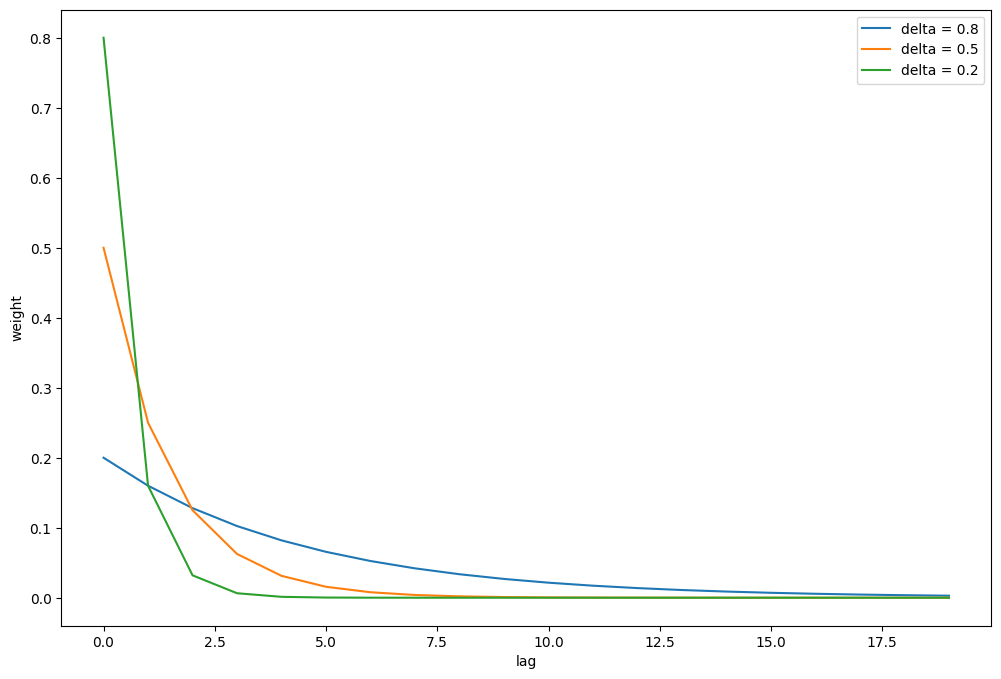

In [66]:
plot_weight([0.8, 0.5, 0.2])

横轴表示滞后月数（例如t-3相对于t，滞后3月），纵轴表示该月的权重  
从权重来看， delta越大，越能捕捉长期趋势；delta越小，对短期反应约敏感  
我希望捕捉相对长期、稳定的时序动量趋势，对短期扰动不那么敏感，选择delta = 0.8

In [67]:
rm_ewma_1 = rm1.apply(lambda column: ewma(column, 0.8))
rm_ewma_1

stkcd,000001.SZ,000006.SZ,000011.SZ,000012.SZ,000014.SZ,000019.SZ,000021.SZ,000025.SZ,000026.SZ,000027.SZ,...,688800.SH,688819.SH,830832.BJ,831726.BJ,832000.BJ,832566.BJ,832885.BJ,834599.BJ,835640.BJ,839167.BJ
202109,0.000560,-0.005623,-0.003566,-0.019965,-0.003337,0.001431,-0.025466,-0.009976,-0.014667,0.038883,...,-0.050620,-0.012149,0.071387,0.126571,0.131095,0.092121,0.073875,0.043563,0.014256,0.015448
202110,0.009675,-0.022403,-0.024364,-0.038368,-0.013731,-0.017048,-0.019279,-0.017990,-0.027926,-0.000779,...,-0.005939,-0.023793,0.053807,0.098675,0.071006,0.061547,0.003763,0.031342,-0.015507,-0.013048
202111,-0.012374,-0.020803,-0.021725,-0.013660,-0.004090,-0.012109,-0.005647,-0.006966,-0.010276,0.001128,...,0.089687,0.005777,0.033232,0.078874,0.042274,0.045264,0.039724,0.033989,-0.000658,0.014521
202112,-0.023051,-0.002224,0.000925,-0.009715,0.016718,-0.003446,-0.001697,-0.006108,-0.009044,0.000420,...,0.085288,-0.015358,0.021817,0.099403,0.051639,0.048850,0.010512,0.033466,-0.010190,-0.004415
202201,-0.028405,-0.012386,-0.014315,-0.028382,0.012159,-0.015163,-0.036570,-0.014886,-0.032168,-0.028756,...,0.036813,-0.037895,0.021505,0.046865,0.017859,0.017969,-0.005301,0.012873,-0.029832,-0.029718
202202,-0.030534,-0.012182,-0.016302,-0.037012,0.021188,0.013853,-0.027626,-0.016261,-0.029871,-0.020207,...,0.034651,-0.039343,-0.006606,0.025192,-0.012647,0.002767,-0.024628,-0.012196,-0.034236,-0.044317
202203,-0.031211,0.025420,0.024728,-0.055424,0.095649,0.029799,-0.055341,-0.006737,-0.047182,-0.037790,...,0.032685,-0.056842,-0.014383,-0.011807,-0.033275,-0.011916,-0.048717,-0.032246,-0.056314,-0.069169
202204,-0.030430,-0.018777,-0.012354,-0.092238,0.051817,-0.001571,-0.071547,-0.055303,-0.054599,-0.049703,...,0.004697,-0.086608,-0.074364,-0.033854,-0.063862,-0.009189,-0.072843,-0.024112,-0.065785,-0.136196
202205,-0.039487,-0.008483,0.007648,-0.058570,0.053612,0.044655,-0.034266,0.105224,-0.009055,-0.027690,...,0.001310,-0.035977,-0.051157,0.008240,-0.049092,-0.003246,-0.046656,-0.012500,-0.038733,-0.026575
202206,-0.018806,0.006530,0.011303,0.000914,0.029970,0.016933,-0.014871,0.101584,-0.005005,-0.013534,...,0.038254,-0.012348,-0.028335,0.008456,-0.035001,-0.005125,-0.013811,-0.016749,-0.030478,0.015064


In [69]:
rm_excess_1 = rm1 - rm_ewma_1
rm_excess_1

stkcd,000001.SZ,000006.SZ,000011.SZ,000012.SZ,000014.SZ,000019.SZ,000021.SZ,000025.SZ,000026.SZ,000027.SZ,...,688800.SH,688819.SH,830832.BJ,831726.BJ,832000.BJ,832566.BJ,832885.BJ,834599.BJ,835640.BJ,839167.BJ
month,,,,,,,,,,,,,,,,,,,,,
202109,0.002239,-0.022493,-0.014265,-0.079859,-0.013347,0.005726,-0.101863,-0.039903,-0.058669,0.155531,...,-0.202479,-0.048597,0.285548,0.506284,0.524378,0.368485,0.295499,0.174252,0.057022,0.061790
202110,0.036461,-0.067118,-0.083190,-0.073614,-0.041577,-0.073920,0.024746,-0.032059,-0.053036,-0.158646,...,0.178724,-0.046575,-0.070319,-0.111585,-0.240355,-0.122297,-0.280447,-0.048886,-0.119049,-0.113983
202111,-0.088194,0.006397,0.010555,0.098833,0.038564,0.019756,0.054530,0.044098,0.070602,0.007629,...,0.382504,0.118279,-0.082300,-0.079203,-0.114927,-0.065132,0.143843,0.010590,0.059393,0.110276
202112,-0.042709,0.074319,0.090600,0.015782,0.083231,0.034653,0.015798,0.003432,0.004929,-0.002833,...,-0.017599,-0.084538,-0.045661,0.082116,0.037461,0.014343,-0.116847,-0.002092,-0.038127,-0.075745
202201,-0.021417,-0.040648,-0.060959,-0.074669,-0.018234,-0.046868,-0.139491,-0.035114,-0.092496,-0.116705,...,-0.193901,-0.090149,-0.001250,-0.210153,-0.135123,-0.123524,-0.063251,-0.082373,-0.078569,-0.101209
202202,-0.008514,0.000815,-0.007951,-0.034520,0.036115,0.116062,0.035777,-0.005500,0.009188,0.034196,...,-0.008647,-0.005791,-0.112442,-0.086693,-0.122021,-0.060805,-0.077309,-0.100276,-0.017616,-0.058396
202203,-0.002710,0.150408,0.164121,-0.073649,0.297845,0.063784,-0.110859,0.038098,-0.069243,-0.070330,...,-0.007862,-0.069994,-0.031109,-0.147993,-0.082514,-0.058736,-0.096353,-0.080202,-0.088309,-0.099407
202204,0.003126,-0.176790,-0.148328,-0.147257,-0.175328,-0.125480,-0.064825,-0.194264,-0.029670,-0.047654,...,-0.111954,-0.119066,-0.239922,-0.088190,-0.122345,0.010909,-0.096507,0.032536,-0.037887,-0.268109
202205,-0.036231,0.041175,0.080010,0.134672,0.007177,0.184905,0.149124,0.642107,0.182175,0.088054,...,-0.013549,0.202522,0.092824,0.168377,0.059078,0.023775,0.104748,0.046451,0.108211,0.438484


事前波动率的估计，也采用指数加权平均，但是相对于当期滞后一期

In [72]:
ex_vola = (rm_excess_1 ** 2).apply(lambda column: ewma(column, 0.8)).shift(1)
ex_vola 

stkcd,000001.SZ,000006.SZ,000011.SZ,000012.SZ,000014.SZ,000019.SZ,000021.SZ,000025.SZ,000026.SZ,000027.SZ,...,688800.SH,688819.SH,830832.BJ,831726.BJ,832000.BJ,832566.BJ,832885.BJ,834599.BJ,835640.BJ,839167.BJ
202109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
202110,0.000001,0.000101,0.000041,0.001275,0.000036,0.000007,0.002075,0.000318,0.000688,0.004838,...,0.008200,0.000472,0.016308,0.051265,0.054994,0.027156,0.017464,0.006073,0.000650,0.000764
202111,0.000267,0.000982,0.001417,0.002104,0.000374,0.001098,0.001783,0.000460,0.001113,0.008904,...,0.012948,0.000812,0.014035,0.043502,0.055550,0.024716,0.029701,0.005336,0.003355,0.003209
202112,0.001769,0.000794,0.001156,0.003637,0.000597,0.000957,0.002021,0.000757,0.001888,0.007135,...,0.039620,0.003447,0.012583,0.036056,0.047081,0.020621,0.027899,0.004291,0.003389,0.005000
202201,0.001780,0.001740,0.002566,0.002959,0.001863,0.001005,0.001667,0.000608,0.001515,0.005710,...,0.031758,0.004187,0.010483,0.030194,0.037946,0.016538,0.025050,0.003434,0.003002,0.005147
202202,0.001516,0.001722,0.002796,0.003483,0.001557,0.001244,0.005225,0.000733,0.002923,0.007292,...,0.032926,0.004975,0.008387,0.032988,0.034008,0.016282,0.020840,0.004104,0.003636,0.006166
202203,0.001227,0.001378,0.002250,0.003024,0.001506,0.003689,0.004436,0.000593,0.002355,0.006067,...,0.026356,0.003987,0.009238,0.027893,0.030184,0.013765,0.017867,0.005294,0.002971,0.005615
202204,0.000983,0.005627,0.007187,0.003504,0.018947,0.003765,0.006007,0.000764,0.002843,0.005843,...,0.021097,0.004169,0.007584,0.026695,0.025509,0.011702,0.016151,0.005522,0.003937,0.006468
202205,0.000788,0.010752,0.010150,0.007140,0.021306,0.006161,0.005646,0.008159,0.002451,0.005129,...,0.019384,0.006171,0.017580,0.022912,0.023401,0.009386,0.014783,0.004629,0.003436,0.019551
202206,0.000893,0.008941,0.009400,0.009340,0.017055,0.011767,0.008964,0.088988,0.008598,0.005654,...,0.015544,0.013140,0.015787,0.023999,0.019419,0.007622,0.014021,0.004135,0.005091,0.054095


In [88]:
def TSMOM(rm: pd.DataFrame, delta: float) -> pd.DataFrame:
    """
    计算时间序列动量
    集成了前面指数加权收益率、事前波动率的计算
    前面的过程作为检查
    """
    def _ewma(ser:pd.Series, delta:float) -> pd.Series:
        ser_ewma = pd.Series(dtype=float)
        for i in range(len(rm)):
            idx = ser.index[i]
            if i == 0:
                ser_ewma.loc[idx] = ((1 - delta) * ser.iloc[i]) 
            else:
                 ser_ewma.loc[idx] = (delta * ser_ewma.iloc[i-1] + (1 - delta) * ser.iloc[i]) 
        return ser_ewma
    
    rm_ewma = rm.apply(lambda column: _ewma(column, delta))
    rm_excess = rm - rm_ewma
    ex_vola = (rm_excess ** 2).apply(lambda column: _ewma(column, delta)).shift(1)
    
    tsmom = np.sign(rm_excess.rolling(12, closed='left').mean()) * rm_excess / ex_vola
    return tsmom
    

采用指数加权移动平均，需要保证有连续的收益率序列，其中不含nan值  
数据集2存在nan值，可能原因是公司停牌、或者未上市  
<br>
若是公司停牌，简单将nan值替换为0并不合理，原因如下： 
时序动量因子背后的逻辑，是市场参与者对新信息反应不足，因此股价变动具有趋势性；而如果停牌期间，股价的nan值替换为0，意味着我们假设没有新信息进入市场、股票价格不发生变动；但事实上，停牌期间，仍有公司相关的信息进入市场，并在公司复牌后集中反映在股价上。因此，将nan值替换为0不合理。  

若是公司未上市，则可能会导致公司有效样本量太少（数据集只有两年，且需要预留一年作为滚动窗口计算因子值）  
<br>
因此，综合考虑下，我仅采用数据集1，计算时序动量因子

In [91]:
tsmom = TSMOM(rm1, 0.8)
tsmom = tsmom.dropna()
tsmom

stkcd,000001.SZ,000006.SZ,000011.SZ,000012.SZ,000014.SZ,000019.SZ,000021.SZ,000025.SZ,000026.SZ,000027.SZ,...,688800.SH,688819.SH,830832.BJ,831726.BJ,832000.BJ,832566.BJ,832885.BJ,834599.BJ,835640.BJ,839167.BJ
month,,,,,,,,,,,,,,,,,,,,,
202209,7.910805,4.504988,8.777514,-4.569715,-7.349432,-16.401112,18.867720,-1.206867,15.804352,21.947086,...,-8.642042,-6.538497,-11.149596,-0.327986,-1.609801,-6.711325,3.942399,19.130878,-9.933208,-5.501541
202210,18.263821,16.875526,-5.970834,1.141805,4.654083,-1.788893,-18.460744,-0.254371,-14.570334,-11.233319,...,-7.079469,-15.492619,-2.389226,0.339129,-10.529516,1.994667,-1.144399,-35.286708,-12.954928,-0.754756
202211,-78.188079,-92.031313,-29.879575,1.468119,-39.890086,10.364602,-0.073284,5.775862,18.470653,-14.985666,...,-1.147273,-3.844321,-10.581828,-8.577330,-3.258153,-17.943668,-3.618646,0.414348,24.752276,-7.539302
202212,-0.110843,-1.628506,-3.837378,-9.032114,-3.523247,-5.843524,-11.331637,-4.590779,-14.051378,-9.654479,...,5.833993,-2.468569,7.499034,5.672648,9.381721,10.418481,9.974420,-9.226713,-9.500780,-2.961764
202301,7.228944,-2.704956,-0.045219,-11.271556,0.331245,6.089781,-9.319827,2.401900,17.887018,-0.027845,...,0.598169,1.910115,-2.423188,-9.780493,-14.199435,-21.705529,-36.219906,-8.848603,40.256639,6.001733
202302,-8.289072,-0.200196,0.949235,-6.444123,-3.811963,8.685605,7.469105,-2.294405,-14.337534,-1.187974,...,12.837644,-3.498452,13.967124,4.211003,5.639185,5.672932,-8.147573,1.103815,-14.734978,-4.871348
202303,-12.945871,-4.215750,-18.588619,-4.853853,4.669598,-14.067994,44.733194,-1.634026,-4.903591,-11.369134,...,14.107132,-5.135226,-15.234587,7.778228,-6.900488,13.745337,-2.389964,-6.069823,-30.986177,-7.576709
202304,0.951320,1.762435,3.004708,-3.008421,-1.524655,5.385583,-5.280691,-2.445388,9.279023,24.903573,...,3.454491,-3.199354,10.400654,-3.668450,6.193067,-8.875620,0.075498,29.407417,5.242531,1.667820
202305,-9.111789,-1.458414,2.135577,-11.537206,1.311877,6.196110,19.571690,-0.067664,1.926914,27.162992,...,-14.410793,5.028468,4.888344,11.484898,9.827720,-27.293223,15.904004,5.194329,8.597738,-0.092072


# FF3MOM
参考：
https://zhuanlan.zhihu.com/p/95259084  
Fama E F, French K R. The cross‐section of expected stock returns[J]. the Journal of Finance, 1992, 47(2): 427-465.  
Blitz, D., J. Huij, and M. Martens (2011). Residual momentum. Journal of Empirical Finance, Vol. 18(3), 506 – 521.

计算FF3残差，在每个横截面上需要往前滚动36个月的数据；  
而网盘的数据仅有两年，没有足够的滚动窗口  
因此，我自行收集了2019-2023共5年的数据，以进行两年期回测

# 因子数据预处理

In [103]:
class FactorToolsKit:
    """
    传入数据结构为：
    行：日期
    列：股票code
    值：对应的值
    """
    
    @staticmethod
    def remove_outlier(
        df: pd.DataFrame, 
        criterion: str, 
        remove_method: str = 'winsorize'
    ) -> pd.DataFrame: 
        """
        在横截面去除异常值
        criterion： '3sigma' 或 'precent'
            '3sigma'把超过均值正负3个标准差的数据，视为异常值
            'precent'把左右尾部各2.5%数据视为异常值
        remove_method： 'winsorize' 或 'drop'
            分别是缩尾与截尾
        """
        def _process(row: pd.Series) -> pd.Series:
            if criterion == '3sigma':
                mean = row.mean()
                std = row.std()
                lower_bound = mean - 3 * std
                upper_bound = mean + 3 * std
            elif criterion == 'precent':
                lower_bound = row.quantile(0.025)
                upper_bound = row.quantile(0.9775)
            else:
                raise ValueError("criterion的参数只能为 '3sigma' 或 'precent'")
            
            if remove_method == 'winsorize':
                return_row = row.apply(lambda x: x if x >= lower_bound else lower_bound)
                return_row = return_row.apply(lambda x: x if x <= upper_bound else upper_bound)
            elif remove_method == 'drop':
                return_row = row.apply(lambda x: x if ((x >= lower_bound) & (x <= upper_bound)) else np.nan)
            else:
                raise ValueError("remove_method的参数只能为 'winsorize' 或 'drop'")
            return return_row
        
        return_df = df.apply(_process, axis=1)
        return return_df
    
    @staticmethod
    def standardize(df: pd.DataFrame, method:str='zscore'):
        """
        在横截面标准化数据
        method: 'zscore'  或 'minmax'
        分别为z值标准化 或 min_max标准化
        """
        def _process(row: pd.Series) -> pd.Series:
            if method == 'zscore':
                mean = row.mean()
                std = row.std()
                return row.apply(lambda x: (x - mean)/ std)
                 
            elif method == 'minmax':
                _min = row.min()
                _max = row.max()
                spread = _max - _min
                return row.apply(lambda x: (x - _mim) / spread)
            
        return df.apply(_process, axis=1)
    
    @staticmethod
    def calcu_IC_series(factor_df:pd.DataFrame, next_return:pd.DataFrame):
        """
        计算IC序列
        """
        #初始化待返回的IC序列Dataframe
        IC_df = pd.DataFrame(columns=['rankIC', 'p_value'], index=factor_df.index)
        iters = tqdm(factor_df.iterrows())
        for idx, factor_row in iters:
            return_row = next_return.loc[idx]

            #剔除缺失值
            calcu_df = pd.DataFrame({'factor': factor_row, 'next_return': return_row})
            calcu_df = calcu_df.dropna()

            #计算rankIC
            IC, p = st.spearmanr(calcu_df['factor'], calcu_df['next_return'])
            IC_df.loc[idx] = [IC, p]

            iters.set_description("Processing %s" % idx)

        return IC_df
    


去极值、标准化

In [105]:
tk = FactorToolsKit()
tsmom = tk.remove_outlier(tsmom, '3sigma')
tsmom = tk.standardize(tsmom)

In [ ]:
tsmom.iloc[]

标准化

# 有效性测试